## Часть 1
Напишите скрипт, который скачивает все данные прошедших губернаторских выборов для всех избирательных участков. 

Входная точка [по ссылке](http://www.st-petersburg.vybory.izbirkom.ru/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=2227). Затем нужно перейти на сайты территориальных избирательных комиссий. Результаты нужно сохранить в  `cvs`-файл, `sqlite` базе данных или `parquet`-файле. В итоге должна получиться таблица с полями:
- название ТИК (территориальная избирательная комиссия, некоторое объединение избирательных участков на определенной территории)
- номер УИК (избирательный участок)
- 20 стандартных полей из итогового протокола

Скрипт должен быть в отдельном `*.py` файле или в отдельном `jupyter`-ноутбуке. 

### Часть 2
Используя скаченные данные и `Pandas` (или `PySpark`) посчитайте:
- явку (%) по всем ТИК, результат отсортировать по убыванию
- выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат  (%, учитывать участки на которых проголосовало больше 100 человек)
- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна
- посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)
- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат
- визуализируйте отношение - явка на УИК $\rightarrow$ результат кандидата. 

In [160]:
import lxml.html
import lxml.etree
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import numpy as np

In [161]:
link = "http://www.st-petersburg.vybory.izbirkom.ru/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222"
response = requests.get(link)

In [162]:
soup = BeautifulSoup(response.text, 'lxml')

In [163]:
table = soup.find('table', attrs={'style' : 'width:100%;border-color:#000000'})
links =[x.get('href') for x in table.findAll('a', attrs={'href': re.compile("^http://")})]

In [176]:
def get_table(ref, num):
    table = BeautifulSoup(requests.get(ref).text).find('table', {'style' : 'width:100%;border-color:#000000'})
    if table is not None:
        data = pd.read_html(str(table.findAll('td')), header=0)
        table = data[0].dropna().join(data[1].dropna()).T
        table.reset_index(inplace=True)
        table.columns = table.iloc[1]
        table = table[2:]
        table.insert(loc=0, column='ТИК', value=[f"ТИК №{num}" for i in range(len(table))])
        table.rename(columns={'Unnamed: 1': 'Статистика'}, inplace=True)
        for i in table.columns[2:-3]:
            table[i] = table[i].astype(int)
        oldlen = len(table.columns)
        for i, can in enumerate(table.columns[-3:]):
            table.insert(loc=oldlen-2+2*i, column=can + ' ( % )', value = table[can])
        for i, can in enumerate(table.columns[-6:]):
            if i % 2 == 1:
                table[can] = table[can].apply(lambda x: x.split()[i%2][:-1])
                table[can] = table[can].astype(float)
            else:
                table[can] = table[can].apply(lambda x: x.split()[i%2])
                table[can] = table[can].astype(int)
            
        
    return table

In [177]:
result = pd.concat([get_table(link, i+1) for i, link in enumerate(links)])
result.index = range(len(result))

### №1

In [223]:
def countVote(table):
    return (table[table.columns[7]] + table[table.columns[8]])

In [224]:
summ = result[result['Статистика'] == 'Сумма']
ind = countVote(summ).sort_values(ascending=False).index
summ.loc[ind]

1,ТИК,Статистика,"Число избирателей, внесенных в список избирателей на момент окончания голосования","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования",Число погашенных избирательных бюллетеней,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования","Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования",Число недействительных избирательных бюллетеней,Число действительных избирательных бюллетеней,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Амосов Михаил Иванович,Амосов Михаил Иванович ( % ),Беглов Александр Дмитриевич,Беглов Александр Дмитриевич ( % ),Тихонова Надежда Геннадьевна,Тихонова Надежда Геннадьевна ( % )
281,ТИК №5,Сумма,255414,238300,66733,1600,169967,1598,66561,1796,66363,0,0,9031,13.25,46362,68.02,10970,16.09
699,ТИК №11,Сумма,212151,176435,55603,1417,119415,1415,55280,1503,55192,0,0,10958,19.33,34772,61.33,9462,16.69
1174,ТИК №19,Сумма,143014,123947,51433,2644,69869,2644,51223,579,53288,1,0,8379,15.55,37091,68.86,7818,14.51
1252,ТИК №20,Сумма,153988,127072,50143,1875,75054,1875,50033,1558,50350,0,0,7061,13.60,33241,64.04,10048,19.36
1922,ТИК №29,Сумма,162685,147500,44832,5227,97441,5212,44275,1693,47794,0,0,6424,12.98,32701,66.08,8669,17.52
1118,ТИК №18,Сумма,94434,67559,47349,1314,18896,1314,46600,1076,46838,0,0,5753,12.01,36632,76.45,4453,9.29
1833,ТИК №28,Сумма,175819,147450,46640,1226,99582,1226,46513,1006,46733,2,0,7750,16.23,30515,63.92,8468,17.74
62,ТИК №2,Сумма,147015,134200,44897,1836,87467,1831,44713,1355,45189,0,0,10177,21.87,26213,56.32,8799,18.90
1403,ТИК №22,Сумма,137381,118500,42458,2172,73865,2172,42302,1214,43260,10,5,8526,19.17,27667,62.21,7067,15.89
401,ТИК №6,Сумма,173058,150600,42586,693,107321,691,42536,1094,42133,0,0,7395,17.11,26233,60.69,8505,19.68


### №2

In [235]:
table = result[(result['Статистика'] != 'Сумма') & (100<(result['Число действительных избирательных бюллетеней'] + result['Число недействительных избирательных бюллетеней']))]
idx = table['Беглов Александр Дмитриевич'].idxmax()
table['Статистика'].iloc[idx]

'УИК №371'

### №3

In [244]:
tables = [result[result['ТИК'] == i] for i in table['ТИК'].unique()]

In [257]:
countVote(tables[0]).max() - countVote(tables[0]).min() 

32744

In [258]:
idx = 1;
t = -9999
for i, table in enumerate(tables):
    res = countVote(table).max() - countVote(table).min()
    if (res) > t:
        t = res
        idx = i;
print(f'ТИК №{i}')

ТИК №29


### №4

In [261]:
result.loc[result['Статистика'] != 'Сумма'].groupby('ТИК').apply(lambda x: countVote(x).var())

ТИК
ТИК №1      30901.615301
ТИК №10     46807.147826
ТИК №11     68943.381313
ТИК №12     15246.923707
ТИК №13     43690.750751
ТИК №14     26267.360863
ТИК №15     90093.113793
ТИК №16     10880.861240
ТИК №17     59114.017706
ТИК №18    117756.880135
ТИК №19     77337.300752
ТИК №2      28885.751987
ТИК №20     34127.880360
ТИК №21     82770.046649
ТИК №22    139062.486846
ТИК №23     36238.362033
ТИК №24     26046.969416
ТИК №25     12393.937658
ТИК №26     19514.364876
ТИК №27     14823.530142
ТИК №28     28869.011364
ТИК №29     37633.769993
ТИК №3      10598.855717
ТИК №30     51249.962857
ТИК №4      22016.053846
ТИК №5      16595.774676
ТИК №6      25180.175791
ТИК №7      32739.626962
ТИК №8      77677.373737
ТИК №9      90833.038431
dtype: float64

### №5

In [271]:
table = pd.DataFrame(columns=range(101)).T
table = table.join(result['Амосов Михаил Иванович ( % )'].map(lambda x: round(x)).value_counts())
table = table.join(result['Беглов Александр Дмитриевич ( % )'].map(lambda x: round(x)).value_counts())
table = table.join(result['Тихонова Надежда Геннадьевна ( % )'].map(lambda x: round(x)).value_counts())
table.fillna(0, inplace=True)
table.head()

,Амосов Михаил Иванович ( % ),Беглов Александр Дмитриевич ( % ),Тихонова Надежда Геннадьевна ( % )
0,1.0,0.0,2.0
1,6.0,0.0,4.0
2,6.0,0.0,5.0
3,2.0,0.0,11.0
4,13.0,0.0,10.0


### №6

In [279]:
table = result[result['Статистика'] != 'Сумма']
table['Явка'] = table['Амосов Михаил Иванович ( % )'] + table['Беглов Александр Дмитриевич ( % )'] + table['Тихонова Надежда Геннадьевна ( % )']
table

C:\Users\morememes\Anaconda3\envs\huinya\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1,ТИК,Статистика,"Число избирателей, внесенных в список избирателей на момент окончания голосования","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования",Число погашенных избирательных бюллетеней,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования","Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования",Число недействительных избирательных бюллетеней,Число действительных избирательных бюллетеней,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Амосов Михаил Иванович,Амосов Михаил Иванович ( % ),Беглов Александр Дмитриевич,Беглов Александр Дмитриевич ( % ),Тихонова Надежда Геннадьевна,Тихонова Надежда Геннадьевна ( % ),Явка
1,ТИК №1,УИК №1,1803,1200,587,11,602,11,587,23,575,0,0,110,18.39,345,57.69,120,20.07,96.15
2,ТИК №1,УИК №2,1466,1100,433,14,653,14,430,19,425,0,0,53,11.94,326,73.42,46,10.36,95.72
3,ТИК №1,УИК №3,2092,1600,576,22,1002,22,576,15,583,0,0,155,25.92,332,55.52,96,16.05,97.49
4,ТИК №1,УИК №4,1056,1000,318,4,678,4,318,13,309,0,0,67,20.81,171,53.11,71,22.05,95.97
5,ТИК №1,УИК №5,1827,1400,495,8,897,8,493,16,485,0,0,137,27.35,266,53.09,82,16.37,96.81
6,ТИК №1,УИК №6,1557,1200,453,13,734,13,453,12,454,0,0,118,25.32,263,56.44,73,15.67,97.43
7,ТИК №1,УИК №7,2095,1600,532,17,1051,17,532,13,536,0,0,131,23.86,305,55.56,100,18.21,97.63
8,ТИК №1,УИК №8,1523,1100,590,13,497,13,590,19,584,0,0,127,21.06,364,60.36,93,15.42,96.84
9,ТИК №1,УИК №9,1463,1300,473,26,801,26,473,17,482,0,0,128,25.65,253,50.70,101,20.24,96.59
10,ТИК №1,УИК №10,1629,1200,486,7,707,7,486,14,479,0,0,118,23.94,267,54.16,94,19.07,97.17


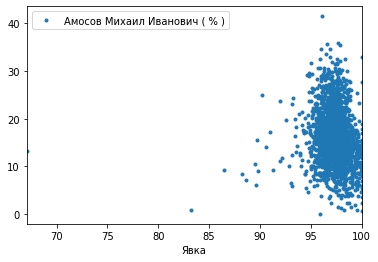

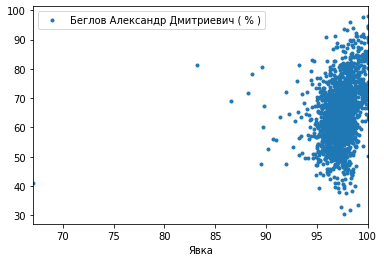

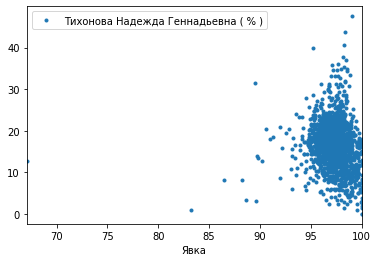

In [289]:
table.plot(x='Явка', y='Амосов Михаил Иванович ( % )', style='.');
table.plot(x='Явка', y='Беглов Александр Дмитриевич ( % )', style='.');
table.plot(x='Явка', y='Тихонова Надежда Геннадьевна ( % )', style='.');